# BBCA Stock Price Prediction Model

## Project Background
Stock price prediction is a significant area of interest in financial markets. It involves using historical price data and machine learning techniques to forecast future stock prices. BBCA is a popular stock price of Bank Central Asia owned by many investors. By creating a prediction model, it'll hopefully minimizes risk for these investors.

## Objectives
- Build machine learning models to forecast BBCA future prices.
- Evaluate each models and choose the best model.

## Dataset
In this project, we use the monthly historical stock prices of Bank Central Asia (BBCA) from January 1, 2015 to January 1, 2025, with the column descriptions provided below.

- Price: The closing price of the stock
- Open: The opening price of the stock
- High: The highest price of the stock
- Low: The lowest price of the stock
- Volume: The total number of shares traded in a single day

In [155]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings
warnings.filterwarnings("ignore")

### Import Data

In [156]:
# load dataset
stock_data = pd.read_csv("bbca.csv")
stock_data

,Date,Price,Open,High,Low,Vol.,Change %
0,01/01/2025,"9,350","9,675","9,925","9,350",1.35B,-3.36%
1,12/01/2024,"9,675","10,000","10,425","9,550",1.35B,-3.25%
2,11/01/2024,"10,000","10,275","10,575","9,800",1.54B,-2.44%
3,10/01/2024,"10,250","10,400","10,875","10,150",1.50B,-0.73%
4,09/01/2024,"10,325","10,375","10,950","10,125",1.63B,0.00%
...,...,...,...,...,...,...,...
116,05/01/2015,"2,825","2,695","2,900","2,680",1.40B,4.82%
117,04/01/2015,"2,695","2,975","3,120","2,580",2.07B,-9.11%
118,03/01/2015,"2,965","2,830","2,965","2,805",1.52B,5.14%
119,02/01/2015,"2,820","2,670","2,910","2,650",1.15B,5.42%


In [157]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121 entries, 0 to 120
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      121 non-null    object
 1   Price     121 non-null    object
 2   Open      121 non-null    object
 3   High      121 non-null    object
 4   Low       121 non-null    object
 5   Vol.      121 non-null    object
 6   Change %  121 non-null    object
dtypes: object(7)
memory usage: 6.7+ KB


In [158]:
# check duplicates and null value
def check_data(dataset):
    print(f"Number of duplicates: {dataset.duplicated().sum()}")
    print(f"Number of null values: {dataset.isnull().sum().sum()}")
    
check_data(stock_data)

Number of duplicates: 0
Number of null values: 0


In [159]:
# convert into datetime
stock_data['Date'] = pd.to_datetime(stock_data['Date'], format='%m/%d/%Y')

# standardize data
def parse_numeric(value):
    if isinstance(value, str):
        if 'M' in value:
            return float(value.replace('M', '')) * 1e6
        elif 'B' in value:
            return float(value.replace('B', '')) * 1e9
        else:
            return float(value.replace(',', ''))
        return value

for column in ['Open', 'High', 'Low', 'Price', 'Vol.']:
    if column in stock_data.columns:
        stock_data[column] = stock_data[column].apply(parse_numeric)

# sort data by Date
stock_data = stock_data.sort_values('Date')
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 121 entries, 120 to 0
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      121 non-null    datetime64[ns]
 1   Price     121 non-null    float64       
 2   Open      121 non-null    float64       
 3   High      121 non-null    float64       
 4   Low       121 non-null    float64       
 5   Vol.      121 non-null    float64       
 6   Change %  121 non-null    object        
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 7.6+ KB


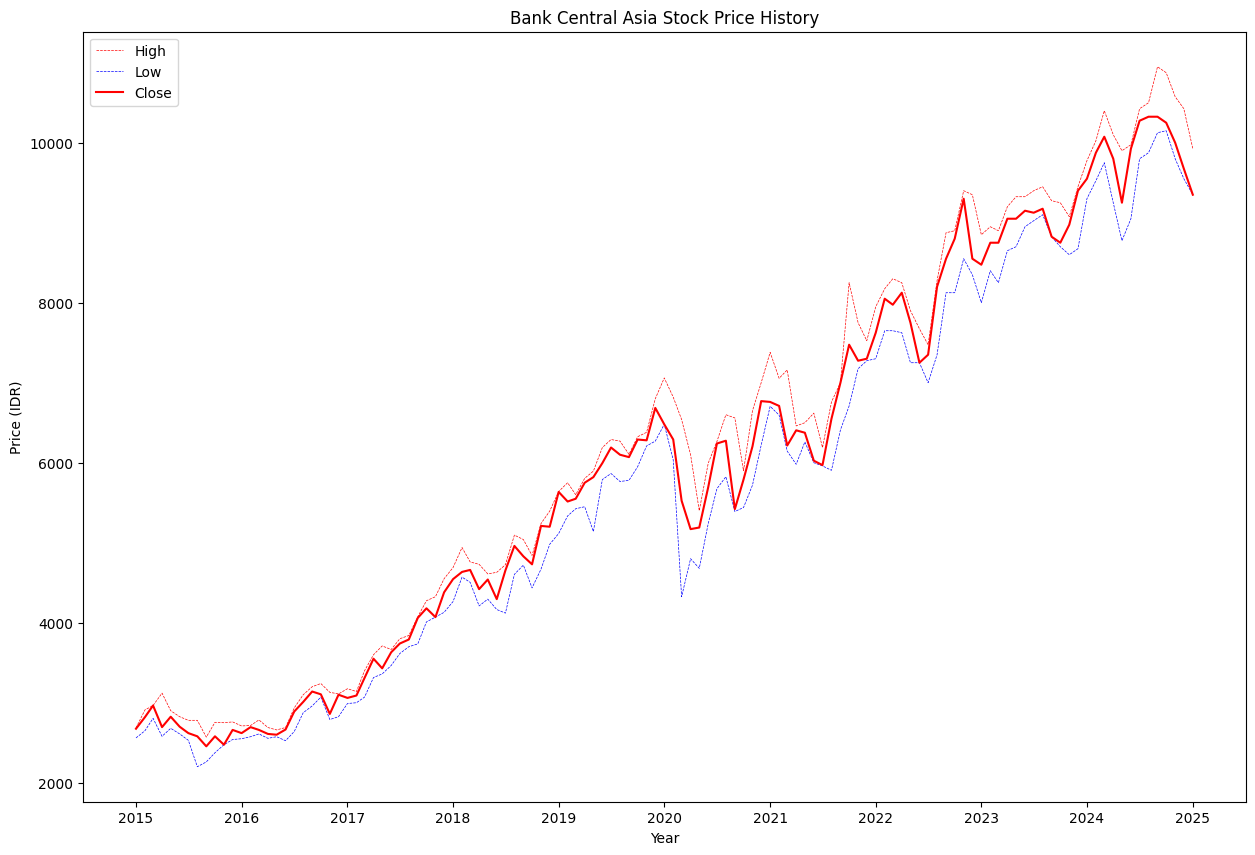

In [160]:
# plot data
plt.figure(figsize=(15, 10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())

x_dates = stock_data['Date']

plt.plot(x_dates, stock_data['High'], 'r', label='High', linestyle='dashed', linewidth=0.5)
plt.plot(x_dates, stock_data['Low'], 'b', label='Low', linestyle='dashed', linewidth=0.5)
plt.plot(x_dates, stock_data['Price'], 'r', label='Close')
plt.xlabel('Year')
plt.ylabel('Price (IDR)')
plt.title('Bank Central Asia Stock Price History')
plt.legend()
plt.gcf()
plt.show()

### Data Preprocessing

In [173]:
close_data = stock_data.filter(['Price'])
dataset = close_data.values
training = int(np.ceil(len(dataset) * .80))
print(training)

97


In [162]:
# create dataset function
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

train_data = scaled_data[0:int(training), :]
# prepare feature and labels
x_train = []
y_train = []

for i in range(60, len(train_data)):
	x_train.append(train_data[i-60:i, 0])
	y_train.append(train_data[i, 0])

test_data = scaled_data[training - 60:, :]
x_test = []
y_test = dataset[training:, :]
for i in range(60, len(test_data)):
	x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

### Model Building

In [163]:
# build LSTM
model = Sequential()
model.add(Bidirectional(LSTM(units=128, return_sequences=True, input_shape=(look_back, 1))))
model.add(Dropout(0.3))
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=32))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=1))


optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_absolute_error'])

# Train model with better batch size and validation split
history = model.fit(x_train, y_train,
                    epochs=50, batch_size=16,
                    validation_split=0.2,
                    callbacks=[early_stop, lr_scheduler])

# predict the testing data
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)



Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - loss: 0.2618 - mean_absolute_error: 0.5003 - val_loss: 0.3246 - val_mean_absolute_error: 0.5642 - learning_rate: 0.0010
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - loss: 0.1345 - mean_absolute_error: 0.3516 - val_loss: 0.1022 - val_mean_absolute_error: 0.3107 - learning_rate: 0.0010
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - loss: 0.0288 - mean_absolute_error: 0.1370 - val_loss: 0.0056 - val_mean_absolute_error: 0.0585 - learning_rate: 0.0010
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 234ms/step - loss: 0.0336 - mean_absolute_error: 0.1604 - val_loss: 0.0066 - val_mean_absolute_error: 0.0607 - learning_rate: 0.0010
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - loss: 0.0307 - mean_absolute_error: 0.1562 - val_loss: 0.0123 - val_mean_absolute_error: 0.0984 - learning_rate: 0.0010
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - loss: 0.0134 - mean_absolute_error: 0.0989 - val_loss: 0.0447 - val_mean_absolute_error: 0

### Evaluation

In [168]:
import numpy as np

X_test = np.array(X_test, dtype=np.float32)
Y_test = np.array(Y_test, dtype=np.float32)

print("X_test dtype:", X_test.dtype)
print("Y_test dtype:", Y_test.dtype)


X_test dtype: float32
Y_test dtype: float32


In [172]:
# evaluation metrics
mse = np.mean(((predictions - y_test) ** 2))
print("MSE", mse)
print("RMSE", np.sqrt(mse))


MSE 633785.8096857468
RMSE 796.1066572298882


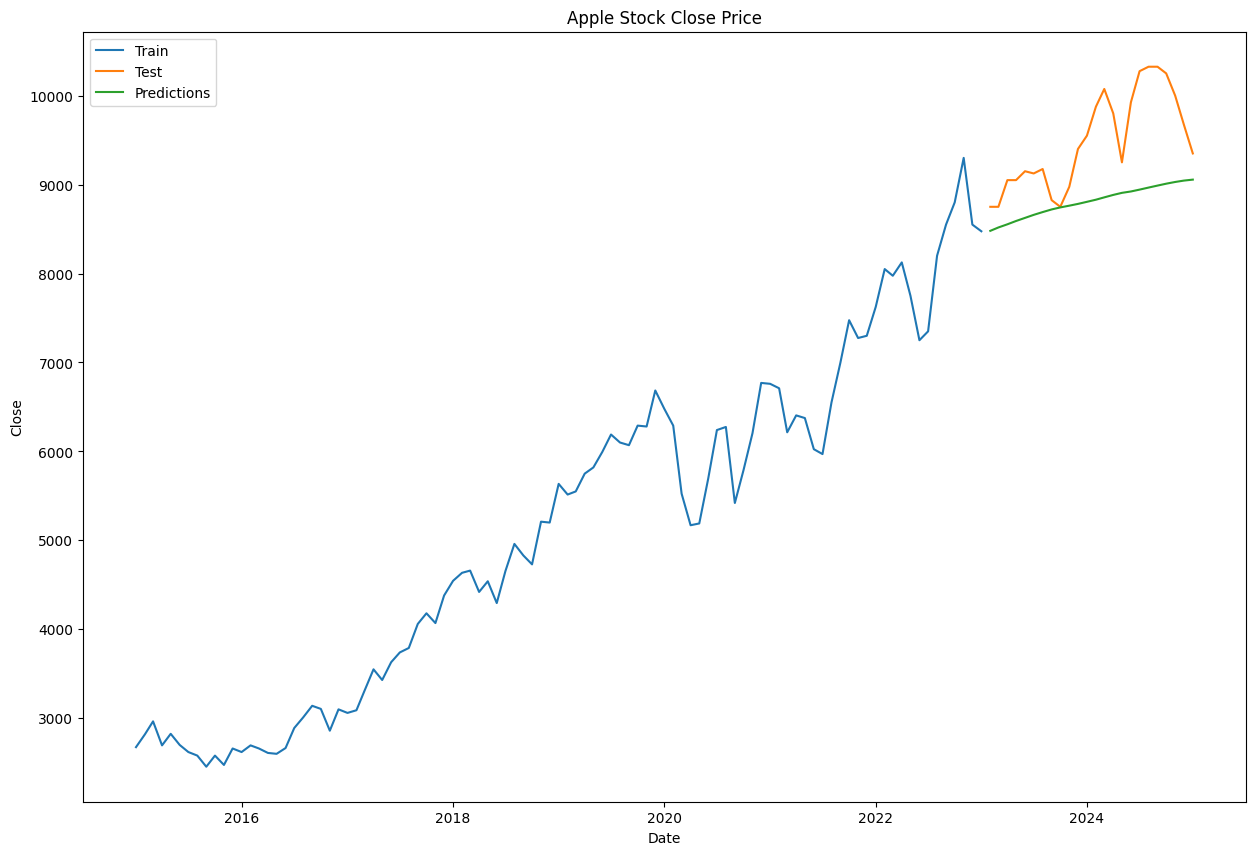

In [166]:
train = stock_data[:training]
test = stock_data[training:]
test['Predictions'] = predictions

plt.figure(figsize=(15, 10))
plt.plot(train['Date'], train['Price'])
plt.plot(test['Date'], test[['Price', 'Predictions']])
plt.title('Apple Stock Close Price')
plt.xlabel('Date')
plt.ylabel("Close")
plt.legend(['Train', 'Test', 'Predictions'])